# Google Analytics 4 (GA4) Data in Pyton Using run_report 

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

In [3]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'bubbly-cascade-398303-75988e28019e.json'
property_id = '318969518'

client = BetaAnalyticsDataClient()

In [31]:
## Format Report - run_report method
def format_report(request):
    response = client.run_report(request)
    print(response.property_quota)
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

In [32]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2024-01-01", end_date="today")],
        return_property_quota = True
    )

request

property: "properties/318969518"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2024-01-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}
return_property_quota: true

In [33]:
format_report(request)

tokens_per_day {
  consumed: 2
  remaining: 1983607
}
tokens_per_hour {
  consumed: 2
  remaining: 398302
}
concurrent_requests {
  consumed: 0
  remaining: 50
}
server_errors_per_project_per_hour {
  consumed: 0
  remaining: 50
}
potentially_thresholded_requests_per_hour {
  consumed: 0
  remaining: 120
}
tokens_per_project_per_hour {
  consumed: 2
  remaining: 139976
}



averageSessionDuration  activeUsers
month sessionMedium                                     
01    (none)                     457.673981     139737.0
      (not set)                  262.299927       3646.0
      ADM                          4.867939          5.0
      CX_Team                   1100.302368        237.0
      CX_team                    325.156311         31.0
...                                     ...          ...
07    paid                        63.586105         15.0
      referral                   188.840591      12036.0
      web_push                     4.895613          1.0
      zalo                       142.891907       1722.0
      zcb                         40.718369         20.0

[247 rows x 2 columns]

In [29]:
output_df = format_report(request)

# ## Export to Excel
# output_df.reset_index().to_excel('GA4_python_output.xlsx', sheet_name = 'GA4_report', engine = 'xlsxwriter')

In [30]:
## Export to CSV
output_df.to_csv('GA4_python_output.csv')

# GA4 Monthly Traffic Chart

In [31]:
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
monhtly_users_pivot = pd.pivot_table(output_df, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

In [33]:
monhtly_users_pivot

sessionMedium,(none),(not set),ADM,CPC,CX_Team,CX_team,DATA_TEAM,DK_Gfbz,DM,DM_TEAM,...,onsiteCH3,onsiteCH4,onsiteCH5,organic,paid,referral,web_push,zalo,zcb,{payment_type}
month,,,,,,,,,,,,,,,,,,,,,
01,139737.0,3646.0,5.0,0.0,237.0,31.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,989865.0,0.0,51831.0,50.0,7344.0,0.0,0.0
02,164074.0,4808.0,4.0,0.0,407.0,46.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,1053658.0,0.0,61489.0,39.0,13211.0,0.0,0.0
03,116289.0,5887.0,3.0,252.0,1276.0,26.0,66.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1023780.0,0.0,76503.0,18.0,9634.0,0.0,4.0
04,144972.0,3939.0,0.0,2.0,832.0,27.0,486.0,6.0,0.0,0.0,...,0.0,0.0,0.0,961723.0,4839.0,56168.0,14.0,10617.0,0.0,0.0
05,102522.0,3823.0,3.0,0.0,303.0,27.0,567.0,1.0,0.0,0.0,...,0.0,0.0,0.0,681302.0,13130.0,51449.0,6.0,7104.0,1.0,0.0
06,114730.0,6698.0,2.0,1.0,383.0,29.0,565.0,0.0,0.0,0.0,...,2.0,76.0,5.0,874701.0,1053.0,85930.0,6.0,13204.0,61.0,1.0
07,9658.0,1032.0,0.0,0.0,47.0,1.0,59.0,0.0,0.0,0.0,...,0.0,6.0,0.0,63493.0,6.0,6180.0,0.0,814.0,13.0,0.0


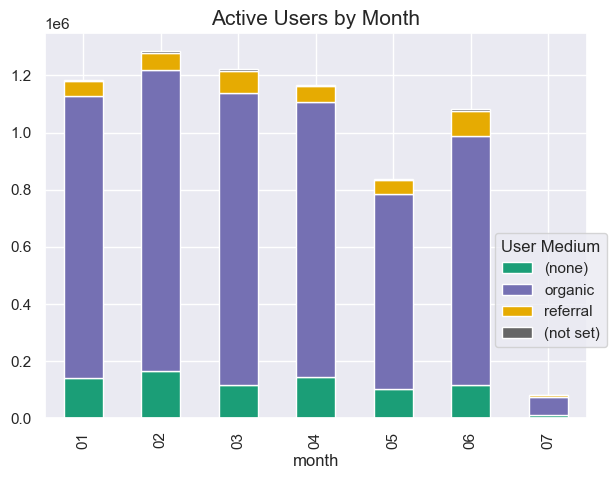

In [34]:
sns.set_theme()
monhtly_users_pivot.plot.bar(y = ['(none)', 'organic', 'referral', '(not set)'], stacked = True,
                             colormap = 'Dark2',
                             figsize=(7,5), title = 'Active Users by Month')
plt.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.5))
plt.title('Active Users by Month', fontsize = 15);

# GA4 Traffic Report

In [41]:
# ## Global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'bubbly-cascade-398303-75988e28019e.json'
property_id = '318969518'
client = BetaAnalyticsDataClient()

## Report dates
end_date = 'today' ## ("today" or "yyyy-mm-dd")
no_days = 60

In [253]:
def calc_start_date(end_date, no_days):
    if end_date == "today":
        start_date = date.today() - timedelta(days=no_days)
    else:
        start_date = date.fromisoformat(end_date) - timedelta(days=no_days)
        
    return start_date.strftime("%Y-%m-%d") 

def produce_report (end_date, no_days, property_id = property_id, client = client):
    daily_traffic_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="date"), 
                        Dimension(name="sessionMedium")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(dimension = {'dimension_name': 'date'}),
                        OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="pagePath")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    
    landing_page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="landingPage")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )

    daily_traffic = format_report(daily_traffic_request).reset_index()
    active_users_pivot = pd.pivot_table(daily_traffic, 
                                     columns=['sessionMedium'], 
                                     index=['date'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
    active_users_pivot.index = active_users_pivot.index.str.slice(start=4)
    
    # Produce pie and line charts
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize = (14, 4), gridspec_kw={'width_ratios': [1, 2]})
    pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)
    pie_data = pie_data[0:10]
    pie_data
    pie_data.plot.pie(ax = axs1,
                      colormap = 'Dark2',
                      y = 'activeUsers',
                      title = 'Active Users by Medium',
                      legend = False, 
                      label = False,
                      startangle = 0, 
                      autopct = lambda p:f'{p:.0f}%').set_ylabel('')
    
    active_users_pivot.plot.line(ax = axs2, 
                                 colormap = 'Dark2',
                                 y = pie_data.index, 
                                 title = 'Active Users by Day')


    axs2.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.6))

    plt.show();
    
    # Produce Top 10 pgaes output tables
    landing_table = format_report(landing_page_users_request)
    landing_table['activeUsers'] = landing_table['activeUsers'].astype('int') 
    page_users_table = format_report(page_users_request)
    page_users_table['activeUsers'] = page_users_table['activeUsers'].astype('int') 
    
    print('\nTop 10 Landing Pages')
    display(landing_table[0:10])
    print('\nTop 10 Visited Pages')
    display(page_users_table[0:10])

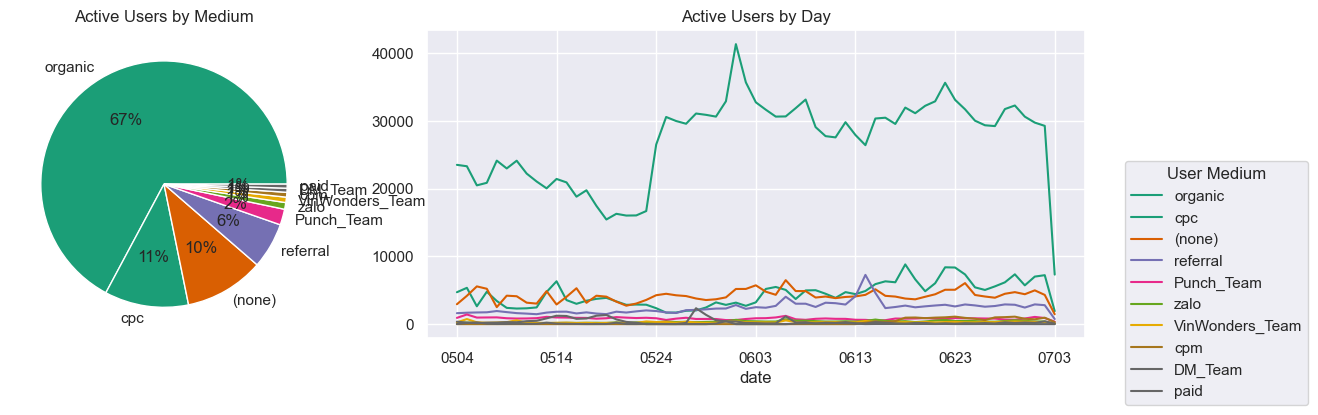


Top 10 Landing Pages


,activeUsers
landingPage,
/vi-VND/search,194103
(not set),166839
/vi/vinwonders-nha-trang,47285
/vi,33604
/ko,24197
/vi/bai-viet-du-lich/12-cung-hoang-dao,19901
/vi/vinwonders-phu-quoc,19874
/vi/bai-viet-du-lich/ma-buu-chinh-ha-noi,19475
/en-USD/search,18753



Top 10 Visited Pages


,activeUsers
pagePath,
/vi-VND/search,235546
/vi/,65004
/vi/vinwonders-nha-trang/,55472
/vi/uu-dai/wonder15-flash-sale/,50706
(not set),45739
/vi/uu-dai/tron-bo-uu-dai-san-pham-hot-tai-nha-trang/,44466
/en-USD/search,32513
/vi-VND/cart,32380
/ko/,29802


In [254]:
produce_report(end_date, no_days)